# K-Means.

### In this Notebook we will apply K-Means clustering on images to segment them into different parts.
### We will segment the image with different values of K and analyse it to find out which value of K gives the best results.

## Importing necessary packages.

In [2]:
from PIL import Image
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
%matplotlib inline
from mpl_toolkits import mplot3d

import plotly.express as px

## We have to import the Picture. 

### After importing the picture, the picture is preprocessed to be suitable to run the K-means algorithm
### We have to do the following to the picture:
    - Convert to a NumPy Array.
    - Change to encoding to float32.
    - Normaalise the Array with MinMax Normalization.
    - Convert the 3 dimensional image array to a 5 dimensional feature vector. The 5-dimensions are normalized vertical and horizontal coordinates of the pixel relative to the top-left corner of the image and the normalized R, G and B values of the image at that pixel.

## Method to apply MinMax Normalisation to the NumPy array of the Image.

In [3]:
def norm_pix(data):
    for i in range(data.shape[2]):
        mi = data[..., i].min() #finding the Minimum value data point in the data.
        ma = data[..., i].max() #finding the Maximum value data point in the data.
        # Now we Traverse over all the point and normalize them using the min max normalization formula
        # normalised = (x-min)/(max-min)
        for j in range(data.shape[0]):
            for k in range(data.shape[1]):
                data[j][k][i]=(data[j][k][i]-mi)/(ma-mi)
    return data

## Method to Convert the Image data to 5 features dataset with X,Y,R,G,B values as features.

- While converting to 5 features dataset, we take in the normalised R,G,B values. 
- The new X,Y values also have to be normalise for the new dataset to be fully normalised.
- In this function we Normalise the X,Y values before converting it into a 5 features dataset.

In [5]:
def create_data(data): #Input is normalised Numpy array.
    shape = data.shape
    final = []
    for i in range(shape[0]):
        t1 = []
        for j in range(shape[1]):
            t2=[i/(shape[0]-1),j/(shape[1]-1)] # normalising the X,Y values and putting normslised values in list t2
            # Appending R,G,B values to t2 to get t2 = [X,Y,R,G,B]
            t2.append(data[i][j][0]) 
            t2.append(data[i][j][1])
            t2.append(data[i][j][2])
            t1.append(t2) # Appending t2 values of column j in row i into list t1 
        final.append(t1) # Appending t1 values which contain  t2 values of row i into list final
    # We now have a list of shape (data.shape[0],data.shape[1],5)
    # We need all [X,Y,R,G,B] values to be in one list.
    # We need list of shape (data.shape[0]*data.shape[1],5)
    data = []
    for i in range(len(final)):
        for j in range(len(final[0])):
            data.append(final[i][j])
    # Alternatively Reshape function can also be used.
    return data

## Method to Input an image and Preprocess the image to return a dataset with 5 features.

- Input the image
- Convert image to a NumPy Array.
- Change to encoding to float32.
- Normaalise the Array with MinMax Normalization.
- Convert the 3 dimensional image array to a 5 dimensional feature vector.

In [7]:
def preprocess(img):
    img = np.array(img) # Converting image img to a NumPy Array.
    img = img.astype('float32') # Changing the encoding of the numpy array img to float32.
    
    norm_img = norm_pix(img) # Normaalising the Array with MinMax Normalization.
    data = create_data(norm_img) # Converting the 3 dimensional norm_img to a 5 feature dataset.
    data = np.array(data) # Converting list to NumPy Array.
    
    return(data)

### We now import the image and preprocess the image to convert it into a dataset.

For this Notebook we will be importing a picture of a Parachute and applying the analysis on this picture. You can change the image path in this part to apply the analysis to ur image.

In [23]:
path = 'parachute.jpg' # path of the input image. You can change to path to the input of your choice.

img = Image.open(path) # Importing the image.
para = preprocess(img) # Retreiving the Dataset from the image. 

para

array([[0.00000000e+00, 0.00000000e+00, 2.64822125e-01, 4.59349602e-01,
        7.91338563e-01],
       [0.00000000e+00, 6.25390869e-04, 2.64822125e-01, 4.59349602e-01,
        7.91338563e-01],
       [0.00000000e+00, 1.25078174e-03, 2.64822125e-01, 4.59349602e-01,
        7.91338563e-01],
       ...,
       [1.00000000e+00, 9.98749218e-01, 2.84584969e-01, 4.87804890e-01,
        8.18897665e-01],
       [1.00000000e+00, 9.99374609e-01, 2.80632406e-01, 4.83739823e-01,
        8.14960659e-01],
       [1.00000000e+00, 1.00000000e+00, 2.80632406e-01, 4.83739823e-01,
        8.14960659e-01]])

We Should get a 2 dimensional array with shape (?,5).

### Reducing Dataset size. (OPTIONAL)

Sometimes due to large images or low computing power the dataset takes a long time to run.
It is seen that if we take random points from the dataset and run the algorithms through this smaller dataset we get similar results.

### This is optional it is not necessary to run this.

In the following cell we randomply pick datapoints which would represent the image in a smaller dataset.

In [12]:
print('Before reducing size: '+str(para.shape))

idx = np.random.randint(len(para), size=10000) # making a list of 10000 random index values from 0 to len(para)
para = para[idx,:] # selecting random datapoints which would represent the image in a smaller dataset.

print('After reducing size: '+str(para.shape))

Before reducing size: (2022400, 5)
After reducing size: (10000, 5)


## K-Means Analysis and image segmentation.

### Now that We have the image in a dataset format we can apply K-Means in this dataset and analyse the segments. 
### We have to do the following steps:
    - Choose a value for K
    - Run K-Means on the dataset and retreive the cluster labels for each datapoint.
    - Plot the datapoints with the cluster label representing the color of the datapoint.
    - Run PCA on the dataset.
    - Plot the PCA with the cluster label representing the color of the datapoint.
    - Run t-SNE on the dataset.
    - Plot the t-SNE with the cluster label representing the color of the datapoint.
    - Calculate and save the K value and the silhouette coefficent for clusters formed with K.
    - Calculate and save the K value and the CH Index for clusters formed with K.

## Method to run K-Means on the dataset and plot the clusters.

In [24]:
def plot_kmean(data,k):
    
    kmeans = KMeans(k, random_state=0).fit_predict(data) # Run K-Means on the data and retreive labels for k clusters.
    
    # Plotting the datapoints with the cluster label representing the color of the datapoint.
    plt.scatter(data[:,1],data[:,0],c=kmeans) 
    plt.gca().invert_yaxis()
    plt.show()
    
    return kmeans

## Method to run PCA on the dataset and return the Principal Components.

In [25]:
def get_pca(data):
    
    # Applying PCA on Data to retreive the Principal Components.
    pca = PCA()
    principalComponents = pca.fit_transform(data)
    principalComponents = pd.DataFrame(data = principalComponents,
                                       columns = ['PC1','PC2','PC3','PC4','PC5'])
    
    return(pca,principalComponents)

## Method to plot the Principal Components with the K-Means labels.

While plotting the principal components we take the first two main principal components of the dataset.

In [26]:
def plot_PCA_2D(principalComponents,labels):
    
    # Plotting the PCA with the cluster labels representing the color of the datapoint.
    plt.scatter(principalComponents['PC1'], principalComponents['PC2'],c=labels,s=1)
    plt.gca().invert_yaxis()
    plt.show()

## Method to run t-SNE on the dataset and return the 2 Entities.

In [27]:
def get_tsne(data, n_components):
    
    # Applying t-SNE on Data to retreive the Entities.
    tsne = TSNE(n_components=n_components, perplexity=50)
    Entities = tsne.fit_transform(data)
    Entities = pd.DataFrame(data = Entities,columns = ['E1','E2'])
    return(tsne,Entities)

## Method to plot the Entities with the K-Means labels.

In [28]:
def plot_tsne(Entities,labels):
    
    # Plotting the t-SNE with the cluster labels representing the color of the datapoint.
    plt.scatter(Entities['E1'], Entities['E2'],c=labels,s=1)
    plt.gca().invert_yaxis()
    plt.show()

Now that we have implemented all the basic functions required for the analysis we will now Implement a function to retrieve all the information.

## Method to do K-Means Analysis.

- Run K-Means on the dataset and retreive the cluster labels for each datapoint.
- Plot the datapoints with the cluster label representing the color of the datapoint.
- Run PCA on the dataset.
- Plot the PCA with the cluster label representing the color of the datapoint.
- Run t-SNE on the dataset.
- Plot the t-SNE with the cluster label representing the color of the datapoint.
- Calculate and save the K value and the silhouette coefficent for clusters formed with K.
- Calculate and save the K value and the CH Index for clusters formed with K.

In [29]:
def kmeans_analysis(data,k):
    kmeans = plot_kmean(data,k) # Plotting the K-Means 
    pca,principalComponents = get_pca(data) # Retreiving Principal Components
    plot_PCA_2D(principalComponents,kmeans) # Plotting the PCA with K-Means labels
    
    tsne , Entities = get_tsne(data,2) # Retreiving t-SNE Entities.
    plot_tsne(Entities,kmeans) # Plotting the t-SNE with K-Means labels
    
    # Calculating the silhouette coefficent.
    print('silhouette coefficent for kmeans K ='+str(n)+' -> '+str(silhouette_score(data, kmeans, metric='euclidean')))
    
    # Calculating the Calinski Harabasz score.
    print('CH Index for kmeans K ='+str(n)+' -> '+str(calinski_harabasz_score(data, kmeans)))

Now we can run the image through kmeans_analysis() with k = 2 to try out this method.

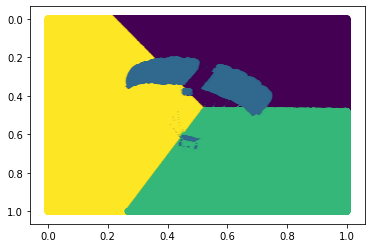

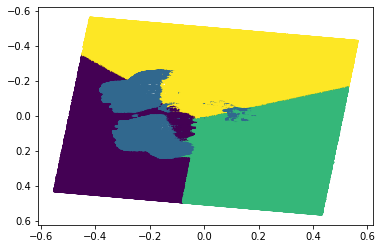

In [ ]:
kmeans_analysis(para,4)